# Latte art experiments

Classifying 4 types of Latte Art: 'heart','tulip','rosetta','swan'.

In [2]:
!pip install -Uqq duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.4 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


In [5]:
from time import sleep
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(keywords=term)
        image_urls = [next(ddgs_images_gen).get("image") for _ in range(max_images)]
        return L(image_urls)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Searching for 'heart latte art'
['https://i.pinimg.com/originals/b4/f3/95/b4f39574cf3332304207e8fe2b18a823.jpg']


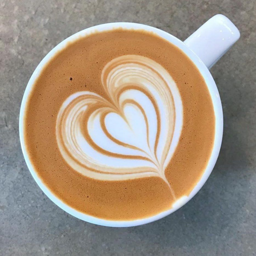

In [6]:
from fastdownload import download_url

urls = search_images('heart latte art', max_images=1)
print(urls)
dest = Path('/kaggle/working')
download_images(dest, urls=urls, timeout=10)

im = Image.open(get_image_files(dest)[0])
im.to_thumb(256,256)

## Download data from DDG

In [7]:
searches = 'heart','tulip','rosetta','swan'
path = Path('/kaggle/working/latte_art')
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} latte art'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(dest, max_size=400, dest=dest)

Searching for 'heart latte art'
Searching for 'tulip latte art'
Searching for 'rosetta latte art'
Searching for 'swan latte art'


## Clean data and show count

In [64]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'num of failed images {len(failed)}')

for o in searches:
    folder = (path/o)
    _, _, files = next(os.walk(folder))
    print(f'Downloaded {len(files)} {o} photos')

num of failed images 0
Downloaded 155 heart photos
Downloaded 199 tulip photos
Downloaded 189 rosetta photos
Downloaded 186 swan photos


## Experiemnt with data augmentation

In [15]:
latte_arts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

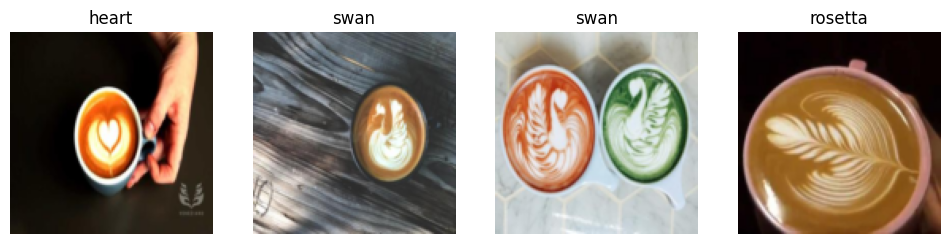

In [16]:
latte_arts = latte_arts.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = latte_arts.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

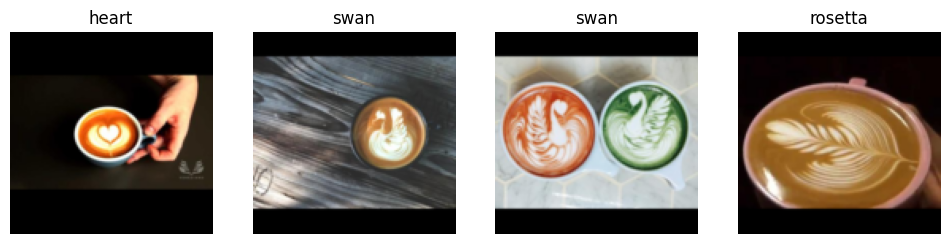

In [17]:
latte_arts = latte_arts.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = latte_arts.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

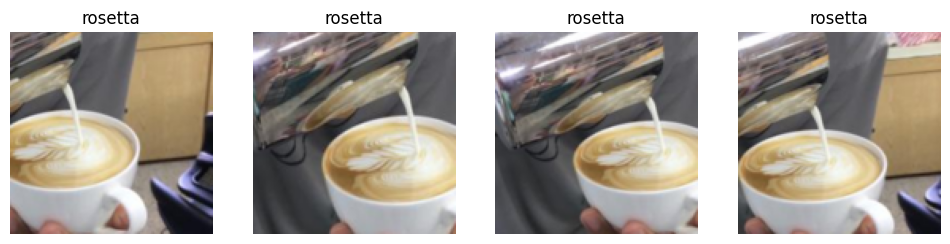

In [31]:
latte_arts = latte_arts.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = latte_arts.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

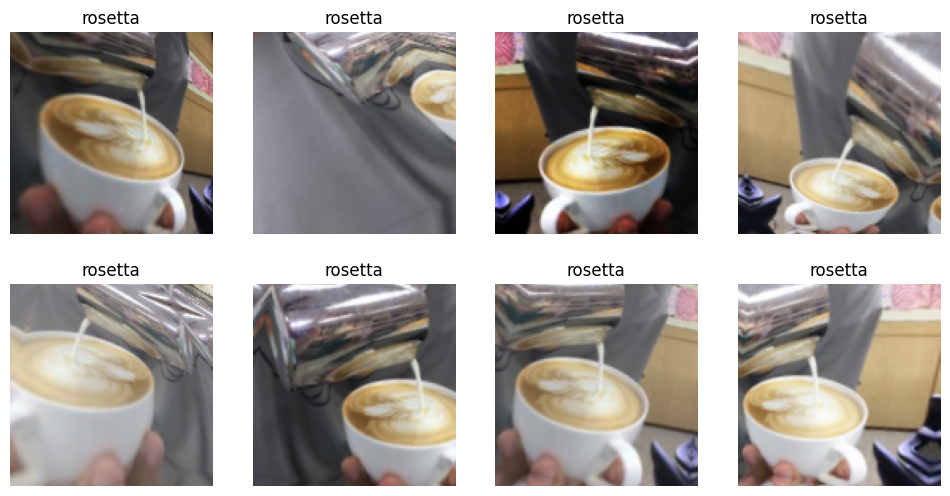

In [33]:
latte_arts = latte_arts.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = latte_arts.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Load data from input

In [32]:
!rm -r '/kaggle/working/latte_art'

In [33]:
searches = 'heart','tulip','rosetta','swan'
input_path = Path('/kaggle/input/latte-art-train/latte_art')
dest_path = Path('/kaggle/working/latte_art')
for o in searches:
    dest = (dest_path/o)
    dest.mkdir(exist_ok=True, parents=True)
    resize_images((input_path/o), max_size=400, dest=dest)

## Prepare actual dataloader

In [34]:
path = Path('/kaggle/working/latte_art')

latte_arts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = latte_arts.dataloaders(path, bs=32)

## Train model

In [ ]:
# 91% accuracy can be achieved
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

In [41]:
predict('/kaggle/input/latte-art/tulip.jpg')

{'heart': 1.8557348084868863e-05,
 'rosetta': 0.011375649832189083,
 'swan': 5.826620326843113e-05,
 'tulip': 0.9885475635528564}

## Evaluation

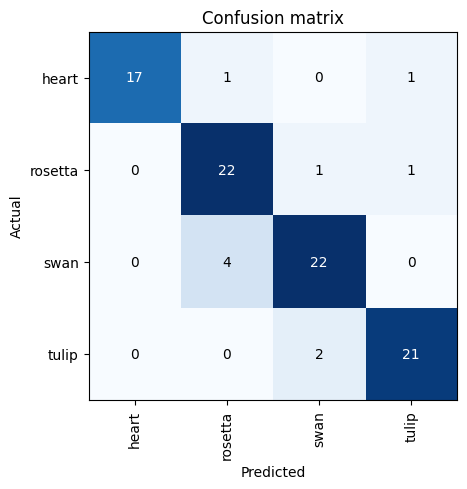

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

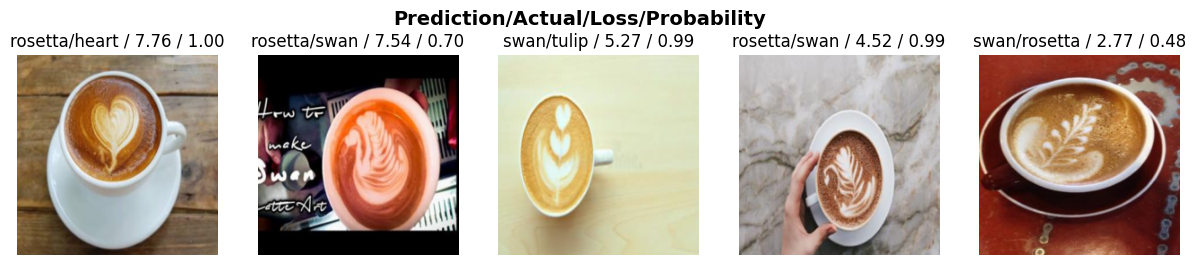

In [43]:
interp.plot_top_losses(5, nrows=1)

## Data Cleaning

In [44]:
from fastai.vision.widgets import *

In [45]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Remove if needed

In [31]:
for idx in cleaner.delete():
    shutil.rm(str(cleaner.fns[idx]))

## Model Export

In [46]:
learn.export('model.pkl')

## Download output

In [29]:
%cd /kaggle/working
!rm latte-art-dataset.zip
!zip -q -r latte-art-dataset.zip latte_art

from IPython.display import FileLink 
FileLink(r'latte-art-dataset.zip')

/kaggle/working


/kaggle/working/latte-art-dataset.zip